In [130]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import random

In [131]:
url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'
response = requests.get(url)
data = np.load(BytesIO(response.content))

x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']

train_filter = np.where((y_train == 0) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))

X_train = x_train[train_filter]
Y_train = y_train[train_filter]
X_test = x_test[test_filter]
Y_test = y_test[test_filter]

X_train = X_train.reshape((X_train.shape[0], 784))
X_test = X_test.reshape((X_test.shape[0], 784))

print("Dimensions of Test and Train filtered data: ")
print(X_train.shape)
print(X_test.shape)

Y_train = np.where(Y_train == 0, -1, 1)
Y_test = np.where(Y_test == 0, -1, 1)

Dimensions of Test and Train filtered data: 
(12665, 784)
(2115, 784)


In [132]:
indices_0 = np.where(Y_train == -1)[0]
indices_1 = np.where(Y_train == 1)[0]

np.random.shuffle(indices_0)
np.random.shuffle(indices_1)

val_indices_0 = indices_0[:1000]
val_indices_1 = indices_1[:1000]

train_indices_0 = indices_0[1000:]
train_indices_1 = indices_1[1000:]

val_indices_0 = np.where(Y_train == -1)[0][:1000]
val_indices_1 = np.where(Y_train == 1)[0][:1000]

train_indices_0 = np.where(Y_train == -1)[0][1000:]
train_indices_1 = np.where(Y_train == 1)[0][1000:]

X_train_val = np.concatenate((X_train[val_indices_0], X_train[val_indices_1]))
Y_train_val = np.concatenate((Y_train[val_indices_0], Y_train[val_indices_1]))

X_train_train = np.concatenate((X_train[train_indices_0], X_train[train_indices_1]))
Y_train_train = np.concatenate((Y_train[train_indices_0], Y_train[train_indices_1]))

print("Dimensions of Train set:", X_train_train.shape)
print("Dimensions of Validation set:", X_train_val.shape)

Dimensions of Train set: (10665, 784)
Dimensions of Validation set: (2000, 784)


In [133]:
X = X_train_train.T
X_mean = np.mean(X, axis = 0)
X_centre = X - X_mean
S = np.dot(X_centre, X_centre.T)/(X_centre.shape[1]-1)
eigenvalues, eigenvectors = np.linalg.eigh(S)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
print("Dimensions of U: ")
U = eigenvectors[:, idx]
Y = np.dot(U.T, X_centre)
print(U.shape)

p = 5
Up = U[:, :p]
print("Dimension of Up")
print(Up.shape)
Yp = np.dot(Up.T, X_centre)
X = Yp.T

print("New Dimension of Train Dataset")
print(X.shape)

X2 = X_train_val.T
X2_centre = X2 - np.mean(X2)
Yp2 = np.dot(Up.T, X2_centre)
X2= Yp2.T
print("New Dimension of Validation Dataset")
print(X2.shape)

X3 = X_test.T
X3_centre = X3 - np.mean(X3)
Yp3 = np.dot(Up.T, X3_centre)
X3= Yp3.T
print("New Dimensions of Test Dataset")
print(X3.shape)

Dimensions of U: 
(784, 784)
Dimension of Up
(784, 5)
New Dimension of Train Dataset
(10665, 5)
New Dimension of Validation Dataset
(2000, 5)
New Dimensions of Test Dataset
(2115, 5)


In [134]:
class DecisionStump:
    def __init__(self):
        self.feature = None
        self.threshold = None
        self.alpha = None
        self.polarity = 1

In [142]:
class Adaboost:
    def __init__(self):
        self.stumps = []
        self.val_accuracies = []

    def fit(self, X_train, Y_train, X_val, Y_val):
        numSamples = X_train.shape[0]
        numFeatures = X_train.shape[1]
        weights = np.full(numSamples, (1/numSamples))

        for i in range(300):
            stump = DecisionStump()
            miniError = float('inf')

            for feature in range(numFeatures):
                uniqueValues = np.unique(X_train[:,feature])
                if len(uniqueValues) < 2:
                    continue
                thresholds = np.random.choice((uniqueValues[:-1]+uniqueValues[1:])/2, size=1000, replace=False)
                for threshold in thresholds:
                    polarity = 1
                    predictions = np.ones(numSamples)
                    predictions[X_train[:,feature] < threshold] = -1
                    error = np.sum(weights[predictions!=Y_train])
                    if error>0.5:
                        error = 1-error
                        polarity = -1
                    if error<miniError:    
                        stump.feature = feature
                        stump.threshold = threshold
                        stump.polarity = polarity
                        miniError = error
            
            stump.alpha = 0.5*np.log((1-miniError)/(miniError+1e-10))
            pred = np.ones(numSamples)
            if stump.polarity == 1:                
                pred[X_train[:,stump.feature] < stump.threshold] = -1
                pred[X_train[:,stump.feature] >= stump.threshold] = 1
            else:
                pred[X_train[:,stump.feature] > stump.threshold] = -1
                pred[X_train[:,stump.feature] <= stump.threshold] = 1
            predictions += stump.alpha * pred
            weights *= np.exp(-stump.alpha*Y_train*predictions)
            weights /= np.sum(weights)
            self.stumps.append(stump)
            validationPredictions = self.predict(X_val)
            validationAccuracy = np.mean(validationPredictions == Y_val)
            self.val_accuracies.append(validationAccuracy)
            print(f"Iteration {len(self.stumps)} - Validation accuracy: {validationAccuracy*100:.2f}%")
        plt.plot(range(1, 300+1), self.val_accuracies)
        plt.xlabel('Number of Trees')
        plt.ylabel('Validation Accuracy')
        plt.title('Validation Accuracy vs. Number of Trees')
        plt.show()

    def evalTestData(self, X_test, Y_test):
        bestIteration = np.argmax(self.val_accuracies)
        bestModel = self.stumps[:bestIteration + 1]
        predictions = self.predict(X_test, bestModel)
        accuracy = np.mean(predictions == Y_test)
        print(f"Test accuracy of the best model: {accuracy*100:.2f}%")
    
    def predict(self, X, model=None):
        if model is None:
            model = self.stumps 
        numSamples = X.shape[0]
        predictions = np.zeros(numSamples)
        for stump in model:
            pred = np.ones(numSamples)
            if stump.polarity == 1:                
                pred[X[:,stump.feature] < stump.threshold] = -1
                pred[X[:,stump.feature] >= stump.threshold] = 1
            else:
                pred[X[:,stump.feature] > stump.threshold] = -1
                pred[X[:,stump.feature] <= stump.threshold] = 1
            predictions += stump.alpha * pred
        return np.sign(predictions)

Iteration 1 - Validation accuracy: 98.75%
Iteration 2 - Validation accuracy: 1.25%
Iteration 3 - Validation accuracy: 98.60%
Iteration 4 - Validation accuracy: 47.35%
Iteration 5 - Validation accuracy: 51.95%
Iteration 6 - Validation accuracy: 66.60%
Iteration 7 - Validation accuracy: 53.15%
Iteration 8 - Validation accuracy: 70.10%
Iteration 9 - Validation accuracy: 53.15%
Iteration 10 - Validation accuracy: 71.50%
Iteration 11 - Validation accuracy: 53.15%
Iteration 12 - Validation accuracy: 71.50%
Iteration 13 - Validation accuracy: 53.15%
Iteration 14 - Validation accuracy: 71.45%
Iteration 15 - Validation accuracy: 88.15%
Iteration 16 - Validation accuracy: 71.80%
Iteration 17 - Validation accuracy: 88.15%
Iteration 18 - Validation accuracy: 71.80%
Iteration 19 - Validation accuracy: 88.15%
Iteration 20 - Validation accuracy: 88.25%
Iteration 21 - Validation accuracy: 93.15%
Iteration 22 - Validation accuracy: 92.50%
Iteration 23 - Validation accuracy: 93.15%
Iteration 24 - Valida

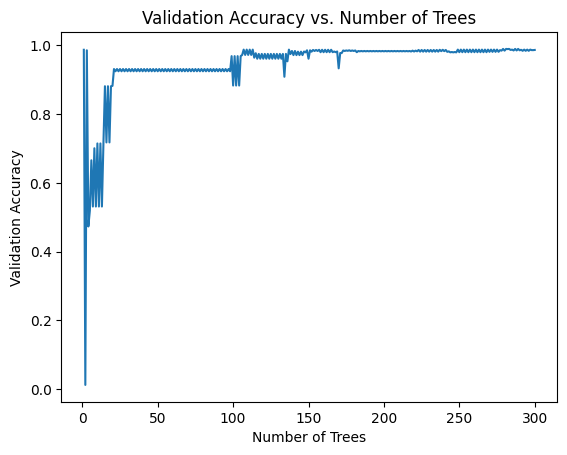

Test accuracy of the best model: 99.24%


In [143]:
adaboost = Adaboost()
adaboost.fit(X, Y_train_train, X2, Y_train_val)
adaboost.evalTestData(X3, Y_test)

In [144]:
print("Dimension of Training dataset:")
print(X.shape)
print("Dimension of Validation dataset:")
print(X2.shape)
print("Dimension of Testing dataset:")
print(X3.shape)

Dimension of Training dataset:
(10665, 5)
Dimension of Validation dataset:
(2000, 5)
Dimension of Testing dataset:
(2115, 5)


In [137]:
class DecisionStump2:
    def __init__(self):
        self.dimension = None
        self.threshold = None
        self.min_ssr = np.inf
        self.leftmean = None
        self.rightmean = None

In [155]:
class DecisionTreeBoosting:
    def __init__(self):
        self.stumps = []
        self.val_mse = []

    def find_best_stump(self, X, y):
        features = X.shape[1]
        best_stump = DecisionStump2()
        midpoints = []

        for dim in range(features):
            sorted_indices = np.argsort(X[:, dim])
            sorted_values = X[sorted_indices, dim]
            random_indices = random.sample(range(len(sorted_values)-1), 1000)
            for i in random_indices:
                threshold = (sorted_values[i]+sorted_values[i+1])/2
                midpoints.append((dim, threshold))

        for dim, threshold in midpoints:
            left_labels = y[X[:, dim]<=threshold]
            right_labels = y[X[:, dim]>threshold]

            left_mean = np.mean(left_labels)
            right_mean = np.mean(right_labels)

            ssr_left = np.sum((left_labels-left_mean)**2)
            ssr_right = np.sum((right_labels-right_mean)**2)
            ssr_total = ssr_left+ssr_right

            if ssr_total < best_stump.min_ssr:
                best_stump.dimension = dim
                best_stump.threshold = threshold
                best_stump.min_ssr = ssr_total
                best_stump.leftmean = left_mean
                best_stump.rightmean = right_mean

        return best_stump

    def predict(self, X, stump):
        return np.where(X[:, stump.dimension] <= stump.threshold, stump.leftmean, stump.rightmean)

    def residue(self, y, predictions):
        return y-predictions

    def mse(self, y, y_pred):
        return np.mean((y-y_pred)**2)

    def fit(self, X_train, y_train, X_val, y_val):
        n_samples = X_train.shape[0]
        residues = y_train.copy()
        predictions = np.zeros(n_samples)

        for i in range(300):
            stump = self.find_best_stump(X_train, residues)
            self.stumps.append(stump)
            pred = self.predict(X_train, stump)
            predictions += 0.01*pred
            residues = self.residue(y_train, predictions)
            predictions_val = np.zeros(len(X_val))
            for s in self.stumps:
                predictions_val += 0.01 * self.predict(X_val, s)
            mse = self.mse(y_val, predictions_val)
            self.val_mse.append(mse)
            print(f"Iteration {i + 1}, MSE for Validation: {mse}")

    def plot_mse(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.val_mse, label='Validation MSE')
        plt.xlabel('Number of Trees')
        plt.ylabel('MSE')
        plt.title('Validation MSE vs Number of Trees')
        plt.show()

    def predict_test(self, X_test):
        predictions_test = np.sum([0.01*self.predict(X_test, s) for s in self.stumps], axis=0)
        return predictions_test

Iteration 1: Validation MSE = 0.9809887255257137
Iteration 2: Validation MSE = 0.9623877915271856
Iteration 3: Validation MSE = 0.9441811963937196
Iteration 4: Validation MSE = 0.926340418374838
Iteration 5: Validation MSE = 0.9089185089286357
Iteration 6: Validation MSE = 0.8918464335557321
Iteration 7: Validation MSE = 0.875113596562669
Iteration 8: Validation MSE = 0.8586344851521408
Iteration 9: Validation MSE = 0.8424325710753274
Iteration 10: Validation MSE = 0.826560154385222
Iteration 11: Validation MSE = 0.8110304571984447
Iteration 12: Validation MSE = 0.7957792243815061
Iteration 13: Validation MSE = 0.7808282052997881
Iteration 14: Validation MSE = 0.7662066463720112
Iteration 15: Validation MSE = 0.7519576167323193
Iteration 16: Validation MSE = 0.7379143331054708
Iteration 17: Validation MSE = 0.724190655947195
Iteration 18: Validation MSE = 0.7106639007064846
Iteration 19: Validation MSE = 0.697406448780921
Iteration 20: Validation MSE = 0.6844422358154597
Iteration 21: 

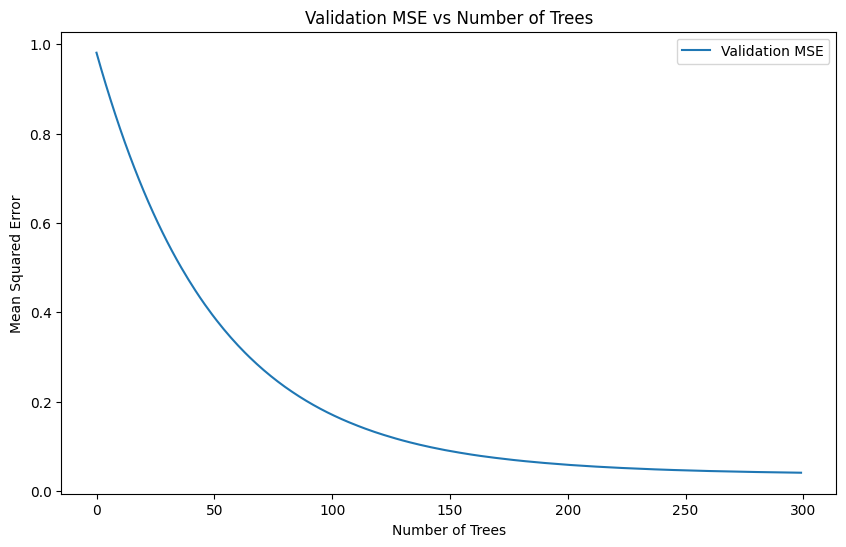

Best model test MSE: 0.01977143774983818


In [157]:
model = DecisionTreeBoosting()
model.fit(X, Y_train_train, X2, Y_train_val)
model.plot_mse()
predictions_test = model.predict_test(X3)
test_mse = model.mse(Y_test, predictions_test)
print(f"Best model test MSE: {test_mse}")